# Variable Settings

In [347]:
# read in the .imzML file
imzml_path = r"small_dataset_pos_20230216/psc_cell_ctrl_3-05-2022_smallarea021623.imzML"
ibd_path = r"small_dataset_pos_20230216/psc_cell_ctrl_3-05-2022_smallarea021623.ibd"
optical_path = r"small_dataset_pos_20230216/20220304_PSC_slide1_ctrl_image1_smallarea021623.tif"
min_cell_pixels = 10
selected_mz = 810.6052
mz_tolerance = 0.1
z_value = 1
intensity_thresh = 2000


# feature m/z
mz_list = [904.6116,906.5586,908.6006,910.6018,912.5388,914.5944,916.6087] #absolute m/z tolerance

##requirements##
## imzML and ibd files must be located in the same folder

# installs & imports

In [2]:
pip install pyimzml

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [345]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import cv2
import copy
import csv
from IPython.display import display
from skimage import feature
from skimage import measure
from skimage.io import imread

In [325]:
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.ImzMLParser import getionimage

# functions

In [6]:
# mean filter applied diagonally
def diag_filter(img):
    temp_img=copy.deepcopy(img)
    for i in range(1,img.shape[0]-1):
        temp_img[i][i]=(img[i-1][i-1]+img[i][i]+img[i+1][i+1])/3
    
    temp_img2=copy.deepcopy(temp_img)
    for m in range(temp_img.shape[0]-2,0,-1):
        temp_img2[m][temp_img.shape[0]-1-m]=(temp_img[m+1][temp_img.shape[0]-2-m]+temp_img[m][temp_img.shape[0]-1-m]+temp_img[m-1][temp_img.shape[0]-m])/3
    return temp_img2

In [7]:
def mean_filter(img):
    # apply mean filter with 3*3 kernal to smooth image, return as 2D numpy array
    img_f = img
    for i in range(2,img.shape[0]-2):
        for j in range(2,img.shape[1]-2):
            block = img[i-1:i+1+1,j-1:j+1+1]
            m = np.mean(block,dtype=np.float32)
            img_f[i][j] = int(m)
    return(img_f)

In [8]:
def plot_by_mz(f,mz_list):
    # given a imzml file read in by ImzMLParser and a list of m/z feature list
    # plot MS images at the specific m/z values
    # Only apply to <= 12 m/z values since will plot at most 2*6 images
    img_f_list = list()
    for mz in mz_list:
        img = getionimage(f, mz, tol=0.1, z=1,reduce_func=sum)
        img_f = mean_filter(img)
        img_f_list.append(img_f)
    fig = make_subplots(rows=2, cols=-(len(img_f_list)//-2),subplot_titles=mz_list)
    for i in range(len(img_f_list)):
        if i+1 <= -(len(img_f_list)//-2):
            fig.add_trace(px.imshow(img_f_list[i]).data[0],1,i+1)
        else:
            fig.add_trace(px.imshow(img_f_list[i]).data[0],2,(i+(len(img_f_list)//-2)+1))
    fig.show()
    return()

In [250]:
def find_cell (img,i):
    # find cell areas - pixel with intensity >= given i
    # intensities of non-cell pixels are set to 0, return as 2D numpy array
    img_cell = img
    img_cell[img_cell<i] = 0
    return(img_cell)

In [10]:
def union (l):
    # union (x,y) of cells identified from different m/z values
    # set cell=1 non-cell=0
    dim = l[0].shape
    union_cell = np.zeros((dim[0],dim[1]))
    non_zeros = list()
    for n in l:
        non_zeros.append(np.argwhere(n>0))
    ones = list()
    for i in non_zeros:
        for (x,y) in i:
            if((x,y) not in ones):
                ones.append((x,y))
    for x, y in ones:
        union_cell[x][y]=1
    return(union_cell)

In [11]:
def dfs(img_cell):
    # depth first search used to find (x,y) of each cell
    # return a list of (x,y) coordinates for each cell
    # first set cell=1 and non-cell=0
    grid = img_cell
    grid[grid != 0]=1
    seen = set()
    l_all = list()
    for r0, row in enumerate(grid):
        for c0, val in enumerate(row):
            l = list()
            if val and (r0, c0) not in seen:
                stack = [(r0, c0)]
                seen.add((r0, c0))
                l.append((r0,c0))
                while stack:
                    r, c = stack.pop()
                    for nr, nc in ((r-1, c), (r+1, c), (r, c-1), (r, c+1)):
                        if (0 <= nr < len(grid) and 0 <= nc < len(grid[0]) and grid[nr][nc] and (nr, nc) not in seen):
                            stack.append((nr, nc))
                            seen.add((nr, nc))
                            l.append((nr,nc))
            l_all.append(l)
    return list(filter(None, l_all))

# main code

In [105]:
#import MSI data
f = ImzMLParser(imzml_path) #ibd path required to parse

C:\Users\lawashburn\Anaconda3\lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning:

Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".



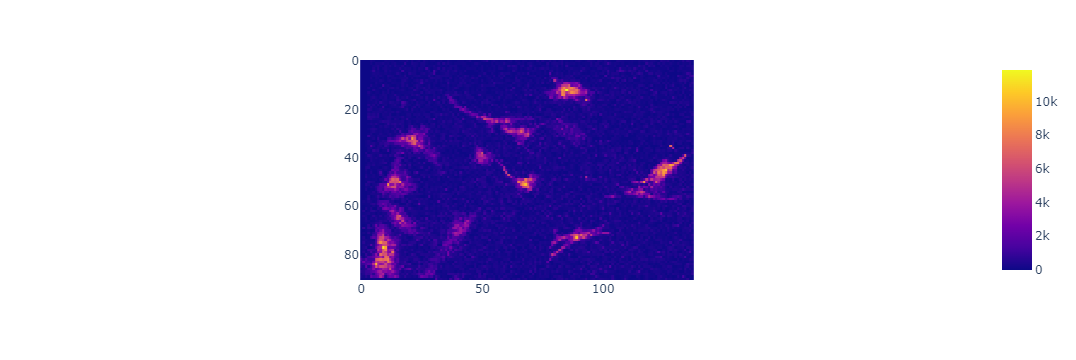

In [326]:
# get an image at some m/z
img = getionimage(f, selected_mz, tol=mz_tolerance, z=z_value,reduce_func=sum) # img stored as 2D numpy array
px.imshow(img)

In [327]:
# dict - {index: x,y}
# a dictionary of pixel information
coord_dict = {}
for i in range(len(f.coordinates)):
    coord_dict[i] = (f.coordinates[i][0], f.coordinates[i][1])

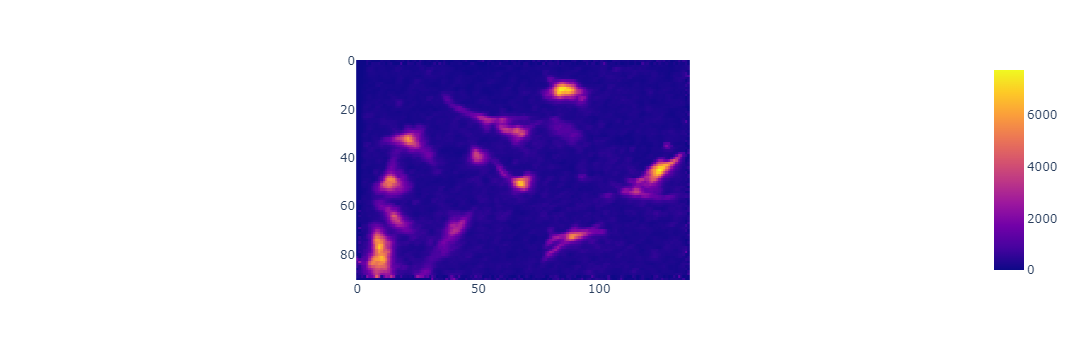

In [328]:
img_f = mean_filter(img)
px.imshow(img_f)

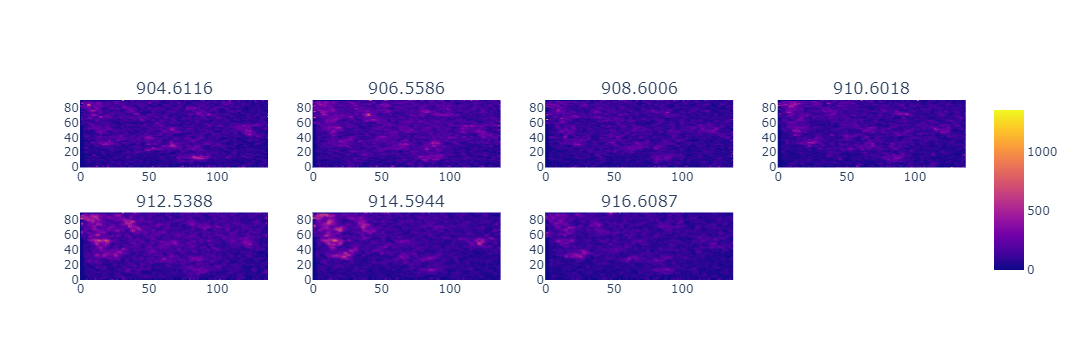

()

In [283]:
plot_by_mz(f,mz_list) # this method can be used to examine if a filter is suitable for some m/z

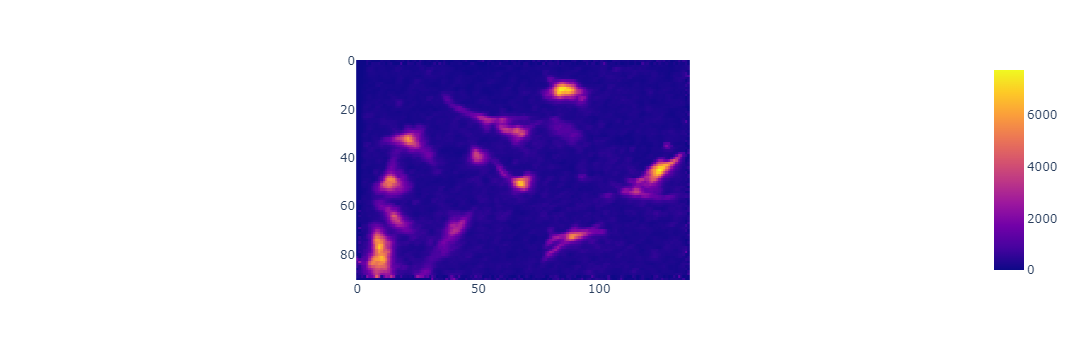

In [329]:
px.imshow(img_f)

In [333]:
# determine if each pixel is a cell or not
img_cell = find_cell(img_f,intensity_thresh)

In [334]:
# split to each cell area
cc = dfs(img_cell)
len(cc) # num of total 'cells' identified

21

In [335]:
cell_localization_df = pd.DataFrame(columns=['x','y','cell_num'])
i = 1 # cell number
for l in cc:
    for x,y in l:
        cell_localization_df.loc[len(cell_localization_df.index)] = [y, x, i] 
    i = i+1

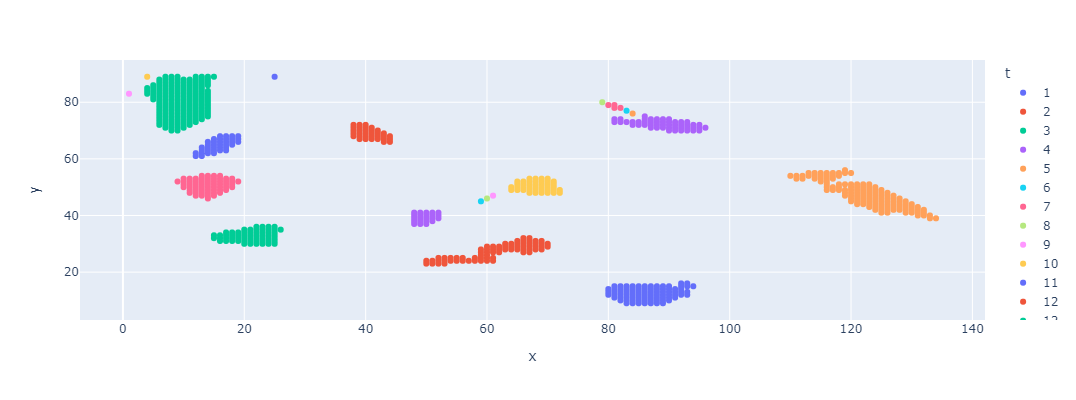

In [336]:
# visualize cells that have been found
cell_localization_df['t'] = cell_localization_df['cell_num'].astype('category')
px.scatter(cell_localization_df, x='x',y='y',color='t',width=500,height=400)

In [337]:
cell_numbers = cell_localization_df['cell_num'].values.tolist()

In [338]:
cell_number_no_dups = []
for aa in cell_numbers:
    if aa not in cell_number_no_dups:
        cell_number_no_dups.append(aa)

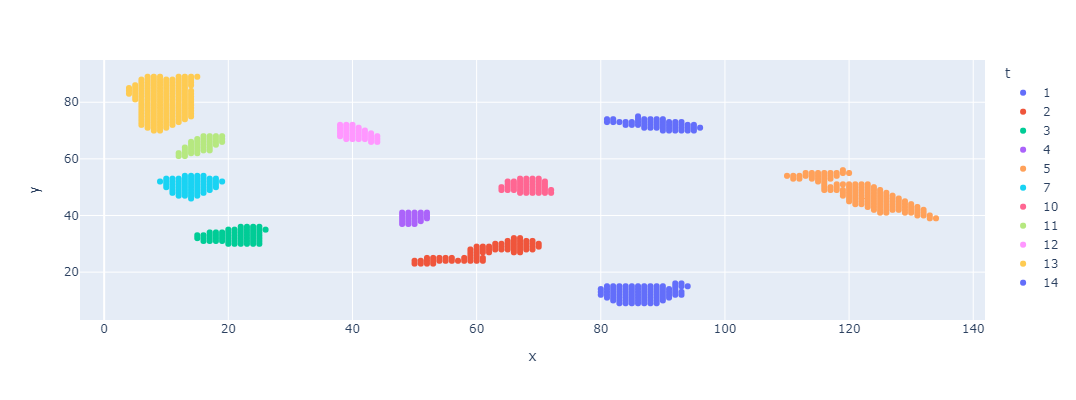

In [339]:
filtered_cells = pd.DataFrame()
        
for bb in cell_number_no_dups:
    cell_local_filter = cell_localization_df[cell_localization_df['cell_num'] == bb]
    if len(cell_local_filter) >=min_cell_pixels:
        filtered_cells = pd.concat([filtered_cells,cell_local_filter])
    else:
        pass
filtered_cells['t'] = filtered_cells['cell_num'].astype('category')    
px.scatter(filtered_cells, x='x',y='y',color='t',width=500,height=400)    

In [340]:
filtered_cells["Identifier"] = filtered_cells['x'].astype(str) +"_"+ filtered_cells["y"].astype(str)

In [341]:
cell_IDs = filtered_cells['Identifier'].values.tolist()

cell_ID_report = []
cell_ID_count = []

for cc in cell_IDs:
    cell_count = cell_IDs.count(cc)
    cell_ID_report.append(cc)
    cell_ID_count.append(cell_count)
    
cell_count_report = pd.DataFrame()
cell_count_report['ID'] = cell_ID_report
cell_count_report['Count'] = cell_ID_count

In [342]:
filtered_cells['coordinate count'] = cell_ID_count
filtered_cells = filtered_cells[filtered_cells['coordinate count'] == 1]

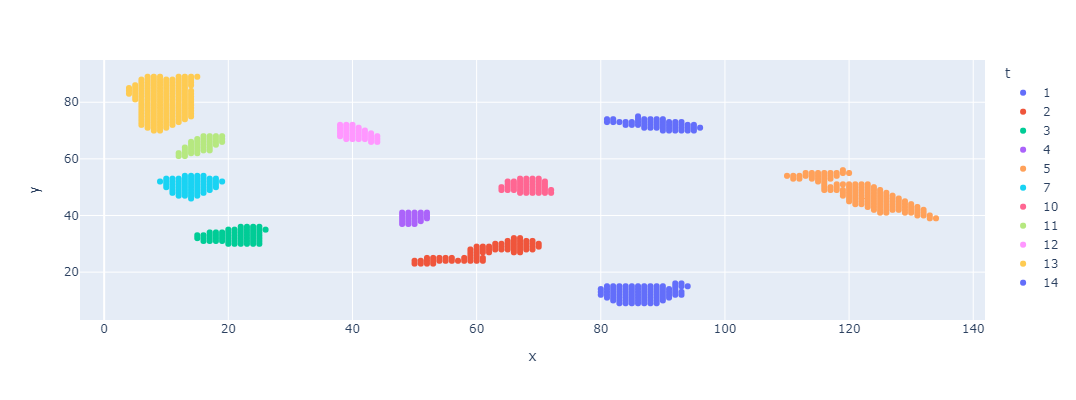

In [355]:
filtered_cells['t'] = filtered_cells['cell_num'].astype('category')    
px.scatter(filtered_cells, x='x',y='y',color='t',width=600,height=400)  


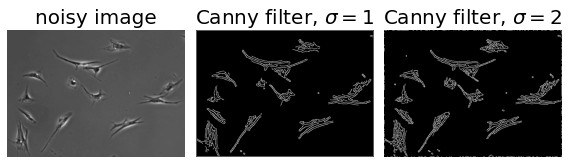

In [348]:
image = imread(optical_path)


# Compute the Canny filter for two values of sigma
edges1 = feature.canny(image)
edges2 = feature.canny(image, sigma=.5)

# display results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('noisy image', fontsize=20)

ax[1].imshow(edges1, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax[2].imshow(edges2, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=2$', fontsize=20)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

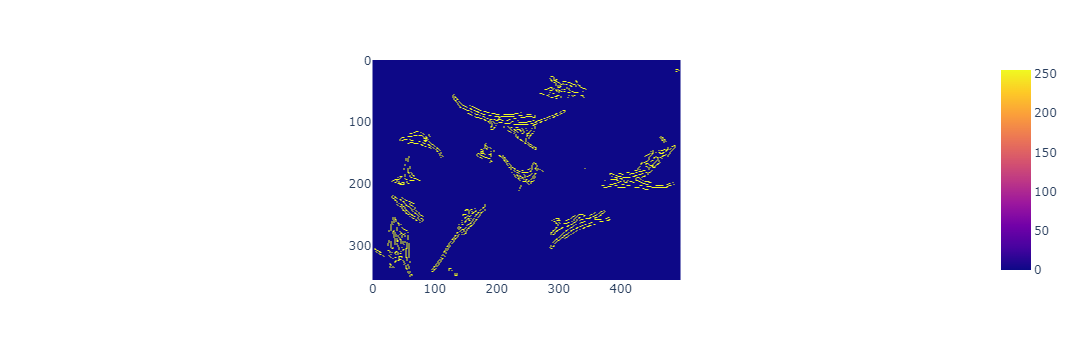

In [353]:
px.imshow(edges1)